# Small convolutional network with data augmentation

### Imports

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
# Dimensions of our images.
img_width, img_height = 224, 224

n_classes = 25
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'

### Data preprocessing

In [3]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1. / 255,      # Normalize pixel values to [0,1]
        shear_range=0.2,       # Randomly applies shearing transformation
        zoom_range=0.2,        # Randomly applies shearing transformation
        horizontal_flip=True)  # Randomly flip the images

datagen = ImageDataGenerator(rescale=1. / 255)

batch_size = 32

# Retrieve images and their classes for train and validation sets
train_generator = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 40805 images belonging to 25 classes.
Found 8856 images belonging to 25 classes.


Example of transformation:

In [4]:
img = load_img('../data/train/arc_de_triomphe/1000610039.jpg')  # PIL image
x = img_to_array(img)  # NumPy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # NumPy array with shape (1, 3, 150, 150)

i = 0
for batch in train_datagen_augmented.flow(x, batch_size=1,
                          save_to_dir='../images/arc_de_triomphe', save_prefix='arc_de_triomphe', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

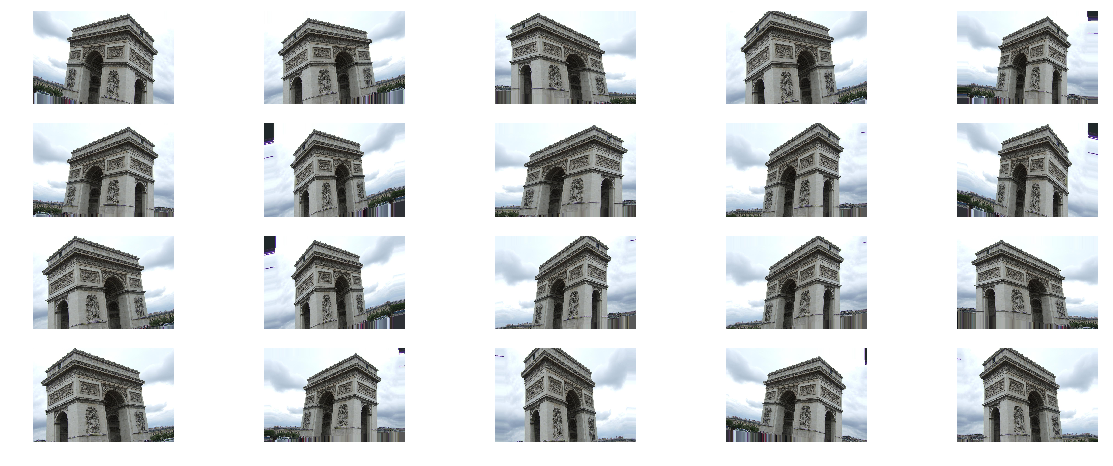

In [6]:
images = []
for img_path in glob.glob('../images/arc_de_triomphe/*.jpeg'):
    images.append(mpimg.imread(img_path))
    
fig = plt.figure(figsize=(20, 10))

columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)
    
fig.savefig('../images/transformations_example.svg', format='svg', dpi=1200)

### Model architecture definition

A simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

In [6]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Training

In [8]:
epochs = 100
# train_samples = 40805
# validation_samples = 8856
train_samples = 4080
validation_samples = 885

In [9]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='../models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.17130, saving model to ../models/augmented.h5
112s - loss: 3.1703 - acc: 0.1053 - val_loss: 2.9112 - val_acc: 0.1713
Epoch 2/100
Epoch 00001: val_acc improved from 0.17130 to 0.24421, saving model to ../models/augmented.h5
105s - loss: 2.6155 - acc: 0.2638 - val_loss: 2.6351 - val_acc: 0.2442
Epoch 3/100
Epoch 00002: val_acc improved from 0.24421 to 0.34606, saving model to ../models/augmented.h5
105s - loss: 2.2778 - acc: 0.3597 - val_loss: 2.3480 - val_acc: 0.3461
Epoch 4/100
Epoch 00003: val_acc improved from 0.34606 to 0.35995, saving model to ../models/augmented.h5
104s - loss: 2.0407 - acc: 0.4230 - val_loss: 2.2603 - val_acc: 0.3600
Epoch 5/100
Epoch 00004: val_acc improved from 0.35995 to 0.45370, saving model to ../models/augmented.h5
105s - loss: 1.8882 - acc: 0.4616 - val_loss: 1.9612 - val_acc: 0.4537
Epoch 6/100
Epoch 00005: val_acc improved from 0.45370 to 0.45486, saving model to ../models/augmented.h5
105s - loss:

### Evaluating on validation set
Computing loss and accuracy:

In [10]:
model.evaluate_generator(validation_generator, validation_samples)

[1.3029291460431158, 0.64874893984688109]

Learning curve:

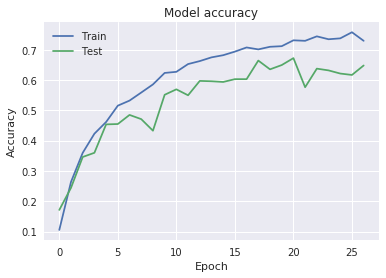

In [11]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('../images/data_augmentation.svg', format='svg', dpi=1200)

**Thanks to data-augmentation, the accuracy on the validation set improved to ~80%**

### Saving the model as JSON

In [12]:
with open('../models/data_augmentation.json', 'w') as f:
    f.write(model.to_json())